Calculate ensemble of sea level projections

In [7]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from alldata import AllData
from ensemble import EnsembleMember,FullEnsemble

np.set_printoptions(precision=2)
%matplotlib notebook
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read data

In [19]:
ad = AllData()
ad.usefanom = True
ad.gather(update=False)
#Select subsection of models for rapid calculation
#ad.ds = ad.ds.isel(ism=slice(0,4),esm=slice(0,4))

fe = FullEnsemble(ad)
fe.gather(force_update=True)

Gathered all data
Doing a forced update of ensemble calculation
ACCESS-CM2 CISM_NCA 5.61 [1.11 1.14 1.17]                                 


/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:118: RuntimeWarning: overflow encountered in multiply
  m = self.gamma*(T-self.Tf)*np.abs(T-self.Tf)**(bmpexp-1)
/nobackup/users/lambert/miniconda3/envs/kpz/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:133: RuntimeWarning: invalid value encountered in subtract
  dFdt = F[1:t,:]-F[:t-1,:]
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:151: RuntimeWarning: invalid value encountered in multiply
  self.SLR[n,t,:] = np.sum(CRF[::-1]*dFdt,axis=0)
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:149: RuntimeWarning: invalid value encountered in subtract
  dFdt = F[1:t,:]-F[:t-1,:]
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:170: RuntimeWarning: invalid value e

no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    


/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:135: RuntimeWarning: overflow encountered in multiply
  self.IML[n,t,:] = np.sum(CRF[::-1]*dFdt,axis=0)


no convergence in iteration, using n=0 [nan nan]                                    
ACCESS-CM2 FETI_ULB 5.05 [1. 1. 1.]                           


/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:133: RuntimeWarning: overflow encountered in subtract
  dFdt = F[1:t,:]-F[:t-1,:]
/nobackup/users/lambert/miniconda3/envs/kpz/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:149: RuntimeWarning: overflow encountered in subtract
  dFdt = F[1:t,:]-F[:t-1,:]
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:181: RuntimeWarning: invalid value encountered in subtract
  F = IML[1:t,e]-IML[:t-1,e]
/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:135: RuntimeWarning: invalid value encountered in multiply
  self.IML[n,t,:] = np.sum(CRF[::-1]*dFdt,axis=0)


no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
ACCESS-CM2 GRIS_LSC -7.73 [1. 1. 1.]                           
ACCESS-CM2 IMAU_UU 1.50 [1.04 1.04 1.05]                                  
ACCESS-CM2 ISSM_UCI 1.67 [1.02 1.02 1.02]                                 
ACCESS-CM2 MALI_DOE 4.83 [1.11 1.13 1.15]                                 


/nobackup/users/lambert/projects/feedback/notebooks/../src/ensemble.py:181: RuntimeWarning: overflow encountered in subtract
  F = IML[1:t,e]-IML[:t-1,e]


no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
ACCESS-CM2 PISM_DMI 1.89 [1. 1. 1.]                           
no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]                                    
ACCESS-CM2 PISM_PIK -240.23 [1. 1. 1.]                           
ACCESS-CM2 SICO_ILTS 3.32 [1.12 1.13 1.14]                                
CAMS-CSM1-0 CISM_NCA 8.27 [1.19 1.2  1.25]                                
CAMS-CSM1-0 FETI_ULB 4.34 [1.53 1.46 1.46]                                
no convergence in iteration, using n=0 [nan nan]                                    
no convergence in iteration, using n=0 [nan nan]   

Figure settings

In [20]:
plt.style.use('../src/style_paper')
mpl.rc('figure.subplot',left=.15,bottom=.2)

alpha = .3 #Transparency of uncertainty range
perc = [17,83] #Percentiles of uncertainty range

Make and save figure

1.0470430460103488
1.0824001991987404
1.0720192839409728


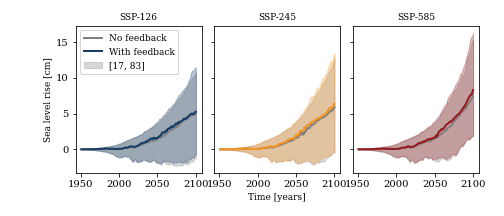

In [28]:
fig,ax = plt.subplots(1,3,sharex=True,sharey='row',figsize=(7,3))

for s,ss in enumerate(ad.ssp):
    #Plot no feedback
    ax[s].plot(fe.time,100*np.nanmedian(fe.slr_nf[s,:,:,:],axis=(0,1)),c='.5',lw=2,label='No feedback')
    ax[s].fill_between(fe.time,100*np.nanpercentile(fe.slr_nf[s,:,:,:],perc[0],axis=(0,1)),100*np.nanpercentile(fe.slr_nf[s,:,:,:],perc[1],axis=(0,1)),color='.5',alpha=alpha,label=perc)

    #Plot with feedback
    ax[s].plot(fe.time,100*np.nanmedian(fe.slr_wf[s,:,:,:],axis=(0,1)),c=ad.scol[ss],lw=2,label='With feedback')
    ax[s].fill_between(fe.time,100*np.nanpercentile(fe.slr_wf[s,:,:,:],perc[0],axis=(0,1)),100*np.nanpercentile(fe.slr_wf[s,:,:,:],perc[1],axis=(0,1)),color=ad.scol[ss],alpha=alpha)

    ax[s].set_title(f'SSP-{ss}')
    
    print(100*np.nanmedian(fe.slr_wf[s,:,:,:],axis=(0,1))[-1]/(100*np.nanmedian(fe.slr_nf[s,:,:,:],axis=(0,1))[-1]))
    #print(100*np.percentile(fe.slr_wf[s,:,:,:],perc[1],axis=(0,1))[-1]/(100*np.percentile(fe.slr_nf[s,:,:,:],perc[1],axis=(0,1))[-1]))
        
ax[0].legend(loc='upper left')

ax[0].set_ylabel('Sea level rise [cm]',fontsize=9)
ax[1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble_lin_{fe.year0}.png',dpi=450,facecolor='w',transparent=False)
plt.show()

#100-100*np.sum(fe.gamma<0,axis=(0,1))/(fe.gamma.shape[0]*fe.gamma.shape[1])

#gampos = np.where(fe.gamma>0,fe.gamma,0)

#np.nanmean(gampos,axis=(0,1))

1.2068323551816245
1.183436637837737
1.1385511828403563


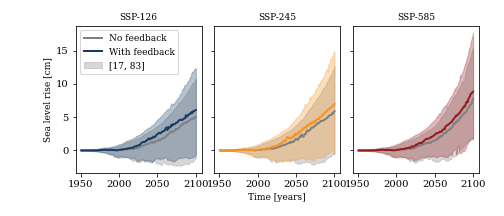

In [18]:
fig,ax = plt.subplots(1,3,sharex=True,sharey='row',figsize=(7,3))

for s,ss in enumerate(ad.ssp):
    #Plot no feedback
    ax[s].plot(fe.time,100*np.nanmedian(fe.slr_nf[s,:,:,:],axis=(0,1)),c='.5',lw=2,label='No feedback')
    ax[s].fill_between(fe.time,100*np.nanpercentile(fe.slr_nf[s,:,:,:],perc[0],axis=(0,1)),100*np.nanpercentile(fe.slr_nf[s,:,:,:],perc[1],axis=(0,1)),color='.5',alpha=alpha,label=perc)

    #Plot with feedback
    ax[s].plot(fe.time,100*np.nanmedian(fe.slr_wf[s,:,:,:],axis=(0,1)),c=ad.scol[ss],lw=2,label='With feedback')
    ax[s].fill_between(fe.time,100*np.nanpercentile(fe.slr_wf[s,:,:,:],perc[0],axis=(0,1)),100*np.nanpercentile(fe.slr_wf[s,:,:,:],perc[1],axis=(0,1)),color=ad.scol[ss],alpha=alpha)

    ax[s].set_title(f'SSP-{ss}')
    print(100*np.nanmedian(fe.slr_wf[s,:,:,:],axis=(0,1))[-1]/(100*np.nanmedian(fe.slr_nf[s,:,:,:],axis=(0,1))[-1]))
    #print(100*np.percentile(fe.slr_wf[s,:,:,:],perc[1],axis=(0,1))[-1]/(100*np.percentile(fe.slr_nf[s,:,:,:],perc[1],axis=(0,1))[-1]))
        
ax[0].legend(loc='upper left')

ax[0].set_ylabel('Sea level rise [cm]',fontsize=9)
ax[1].set_xlabel('Time [years]')

plt.savefig(f'../draftfigs/full_ensemble_lin_{fe.year0}.png',dpi=450,facecolor='w',transparent=False)
plt.show()

#100-100*np.sum(fe.gamma<0,axis=(0,1))/(fe.gamma.shape[0]*fe.gamma.shape[1])

#gampos = np.where(fe.gamma>0,fe.gamma,0)

#np.nanmean(gampos,axis=(0,1))